Successfully loaded data from: ../data/benin-malanville.csv
--- BENIN (benin-malanville.csv) DATA ---

DataFrame Head:
          Timestamp    GHI    DNI    DHI  ModA  ModB   Tamb     RH    WS  WSgust  WSstdev      WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  Comments
0  2021-08-09 00:01 -1.200 -0.200 -1.100 0.000 0.000 26.200 93.400 0.000   0.400    0.100 122.100    0.000  998         0          0.000 26.300 26.200       NaN
1  2021-08-09 00:02 -1.100 -0.200 -1.100 0.000 0.000 26.200 93.600 0.000   0.000    0.000   0.000    0.000  998         0          0.000 26.300 26.200       NaN
2  2021-08-09 00:03 -1.100 -0.200 -1.100 0.000 0.000 26.200 93.700 0.300   1.100    0.500 124.600    1.500  997         0          0.000 26.400 26.200       NaN
3  2021-08-09 00:04 -1.100 -0.100 -1.000 0.000 0.000 26.200 93.300 0.200   0.700    0.400 120.300    1.300  997         0          0.000 26.400 26.300       NaN
4  2021-08-09 00:05 -1.000 -0.100 -1.000 0.000 0.000 26.200 93.300 0.100   0

/home/fentahun/Documents/AIM/solar-challenge-week1/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/tmp/ipykernel_70888/3521430183.py:199: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(median_val, inplace=True)



Cleaned data for Benin saved to ../data/benin_clean.csv

--- 3. TIME SERIES ANALYSIS ---


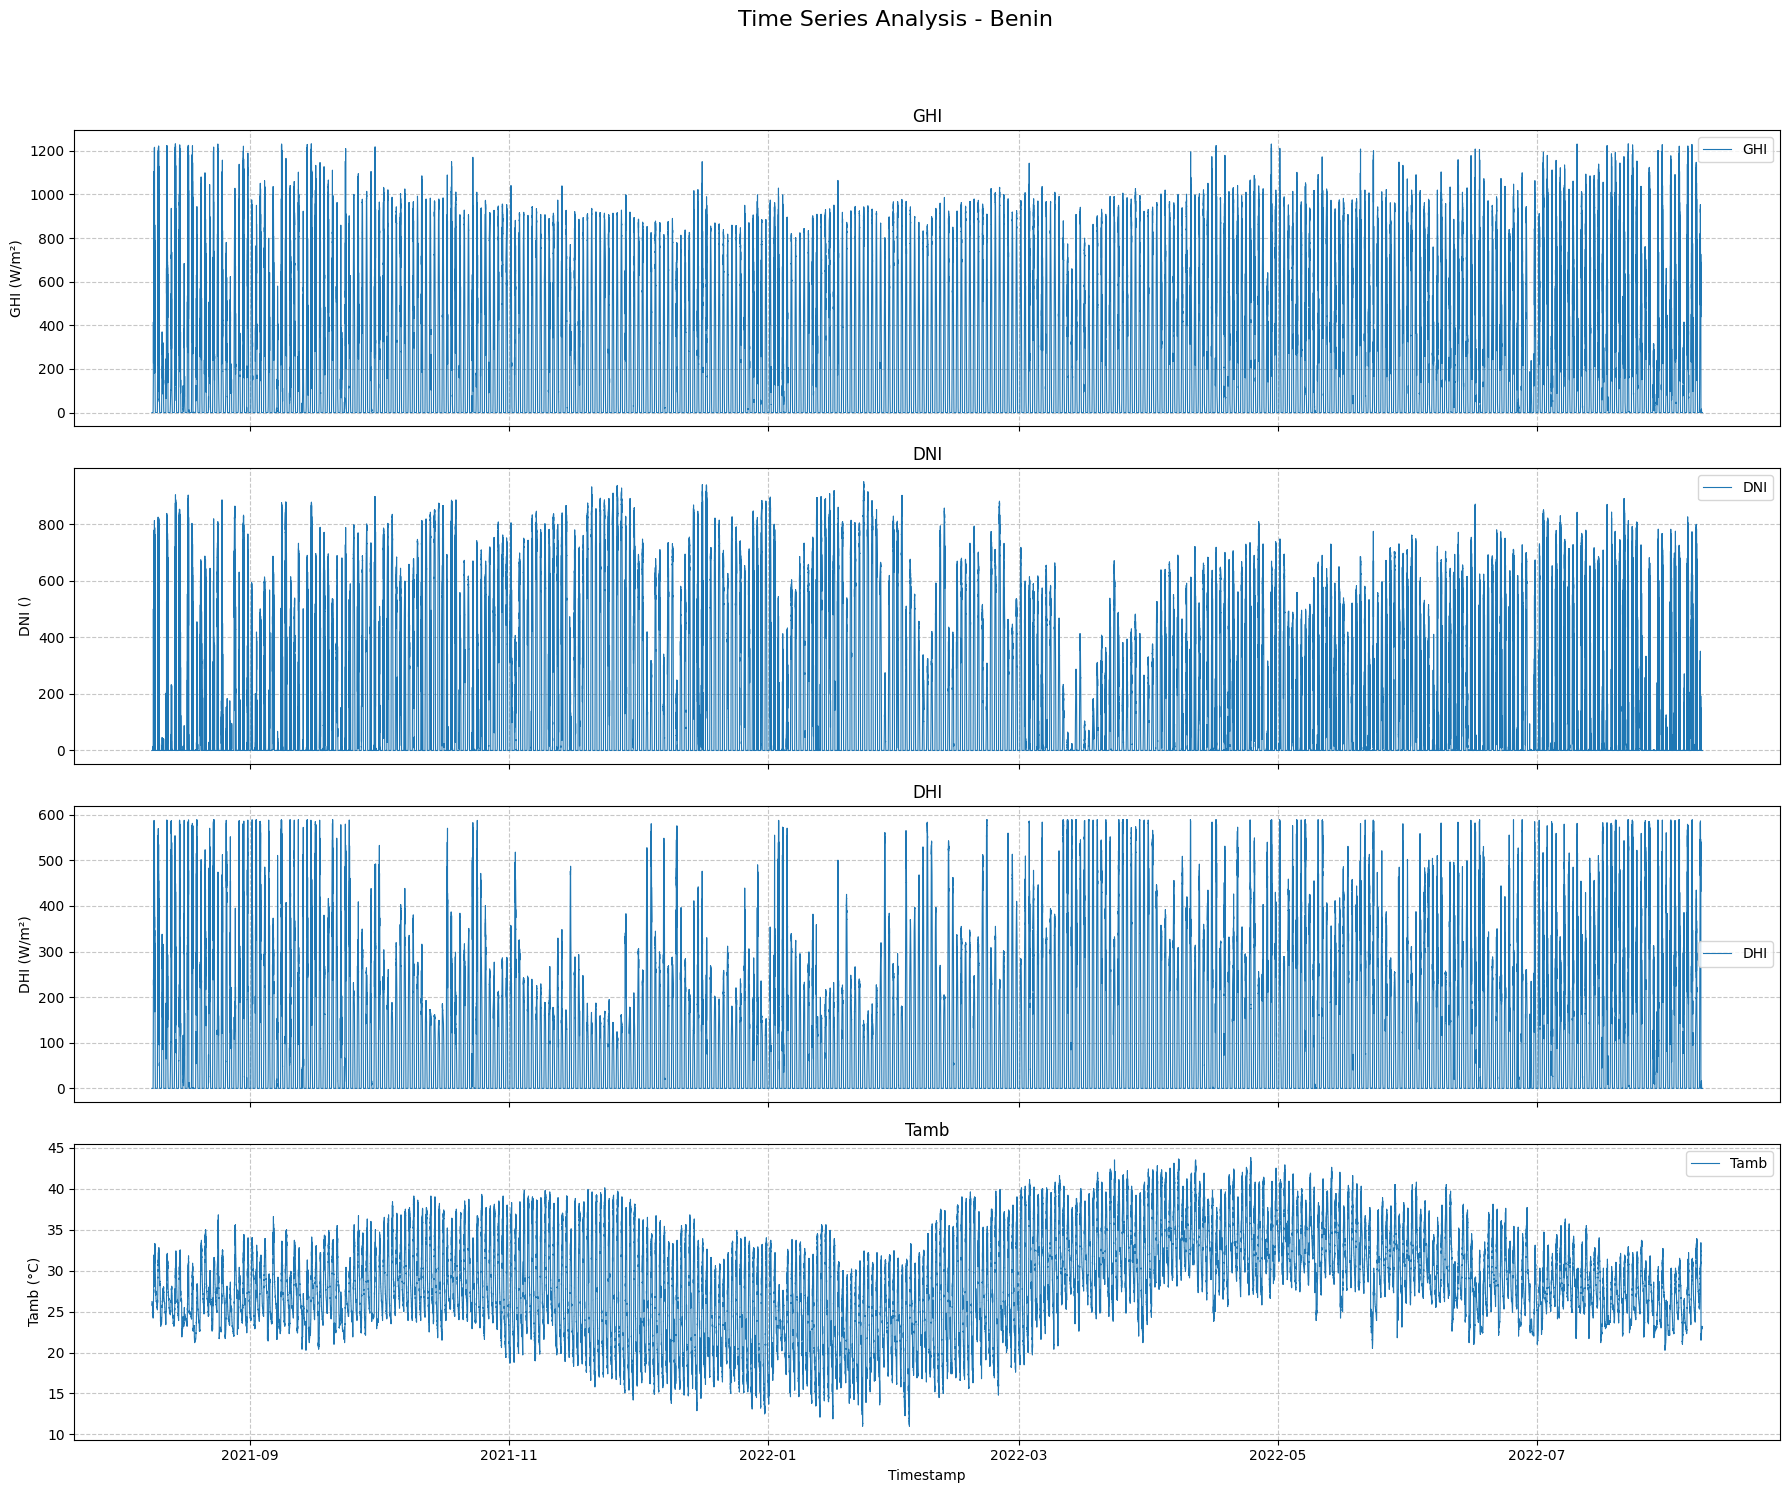

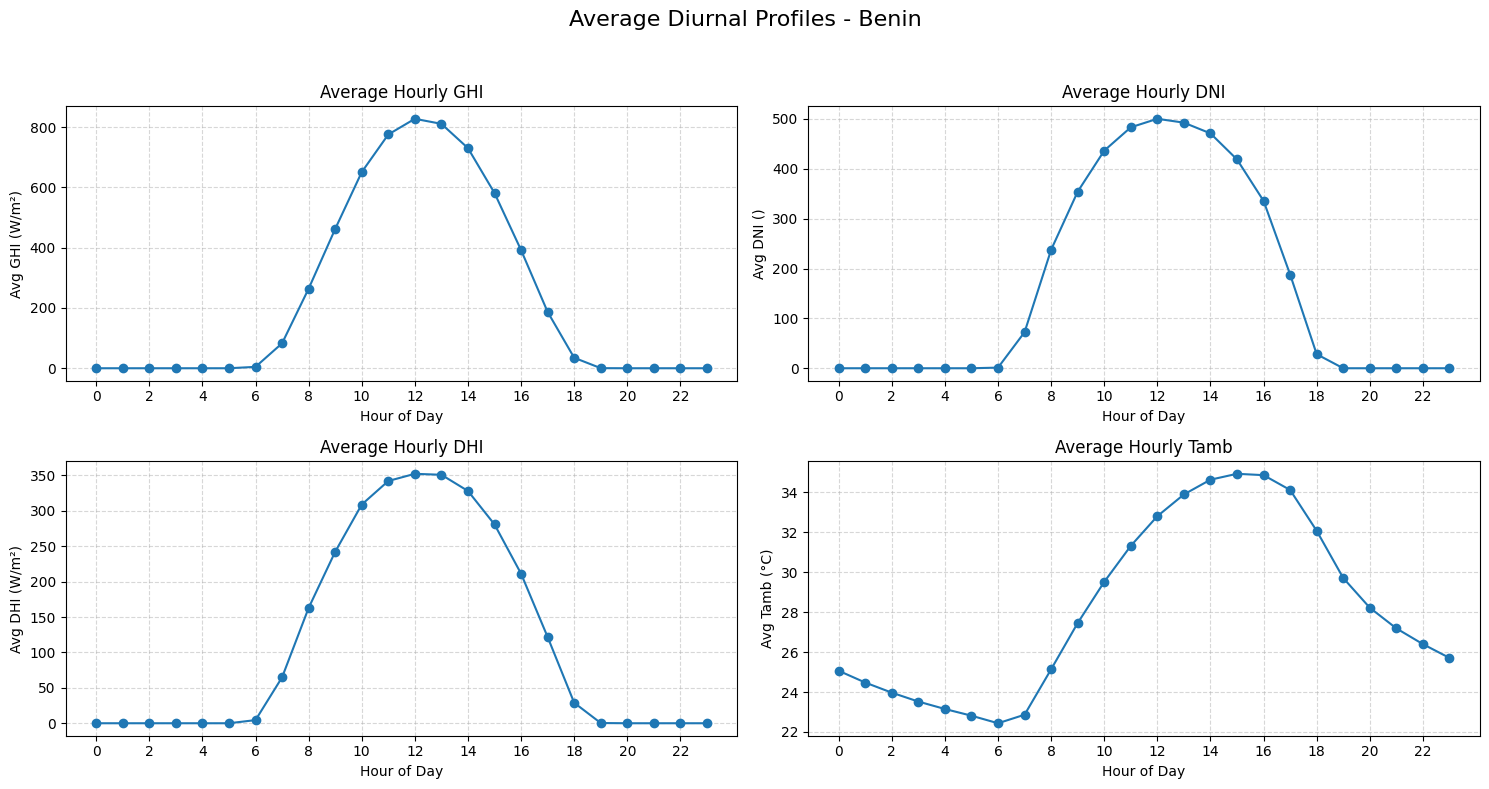

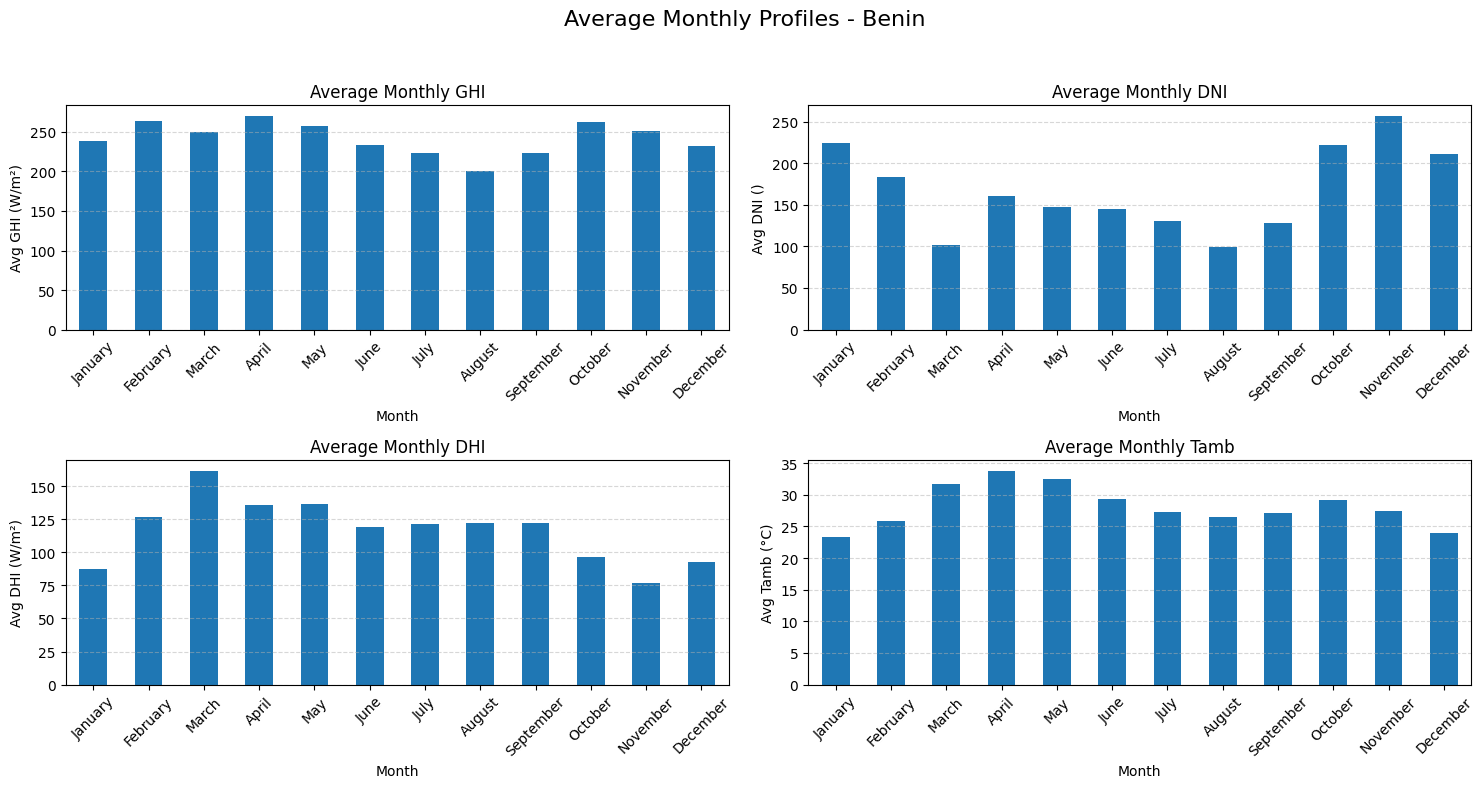


--- 4. CLEANING IMPACT ANALYSIS ---
Number of cleaning events recorded: 485
Avg ModA: Pre-Clean=133.91, Post-Clean=307.23, Improvement=173.32 W/m²
Avg ModB: Pre-Clean=129.37, Post-Clean=301.97, Improvement=172.60 W/m²


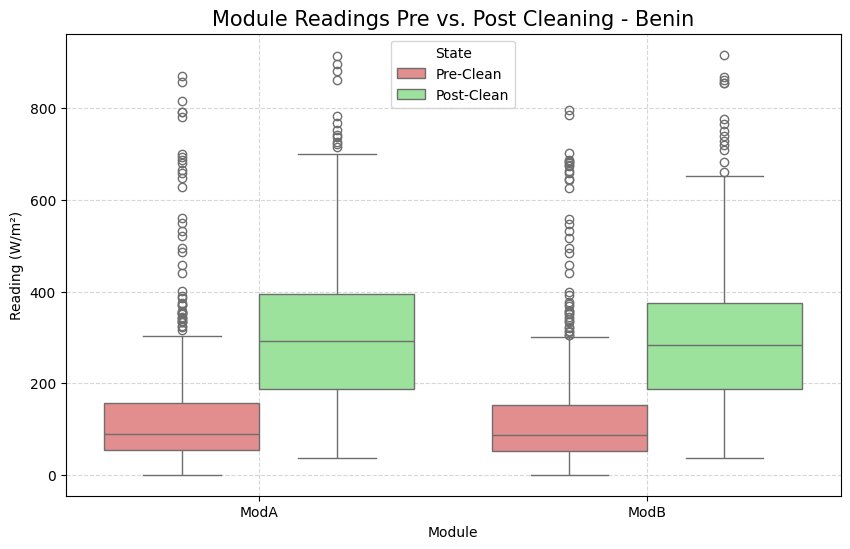


--- 5. CORRELATION & RELATIONSHIP ANALYSIS ---


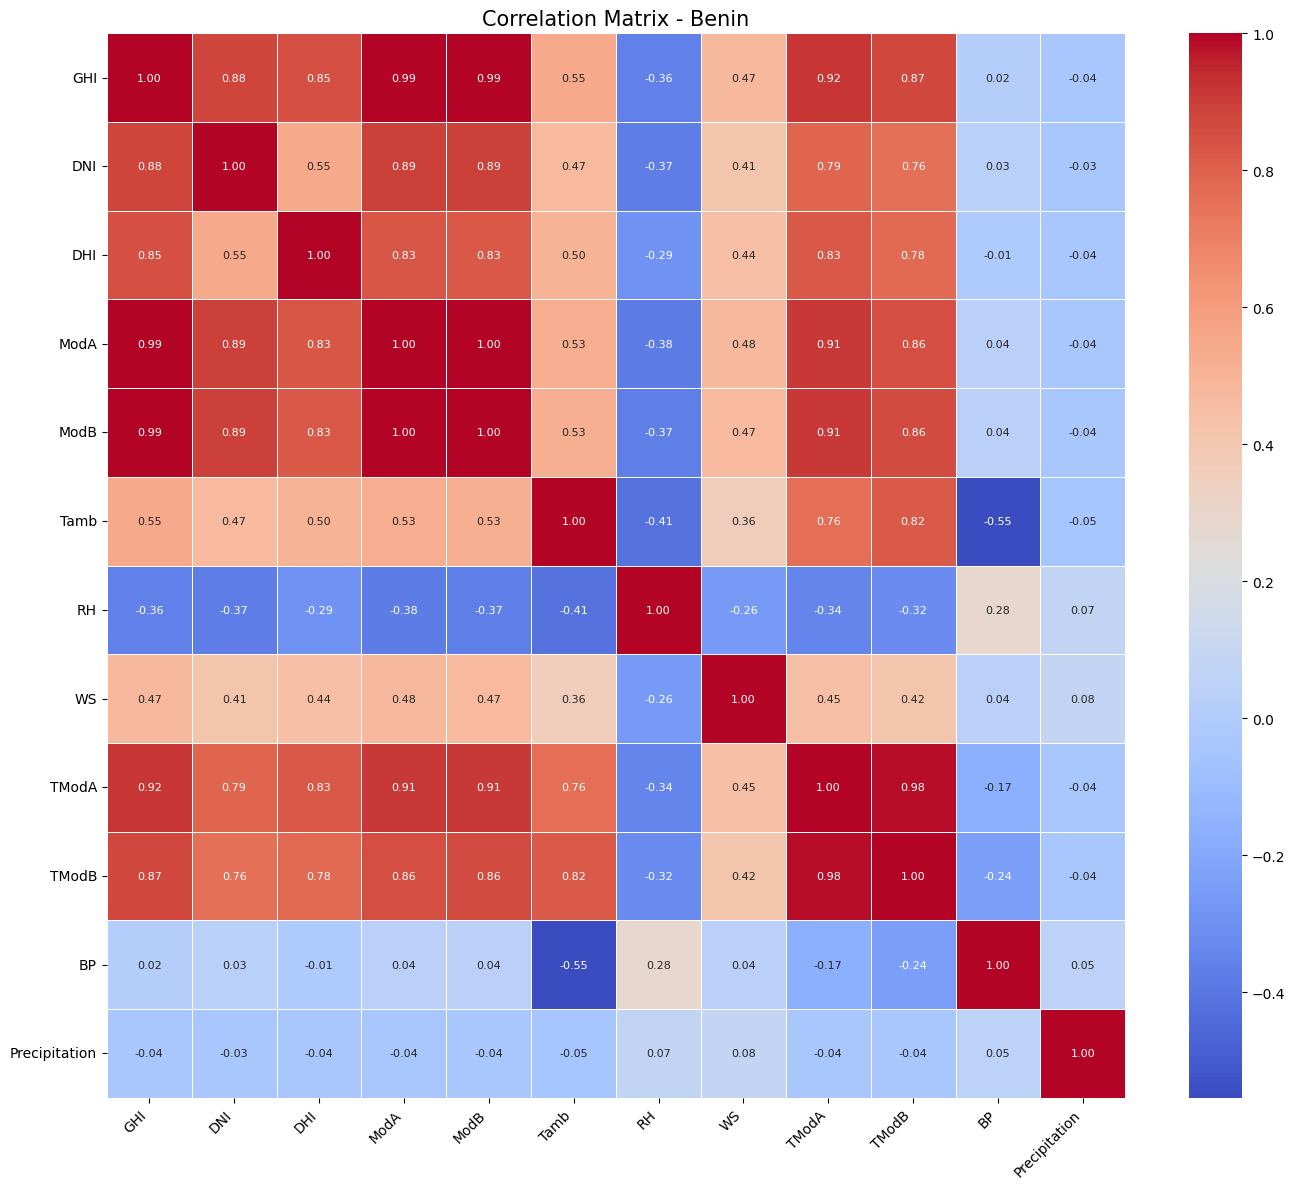


Scatter Plots:


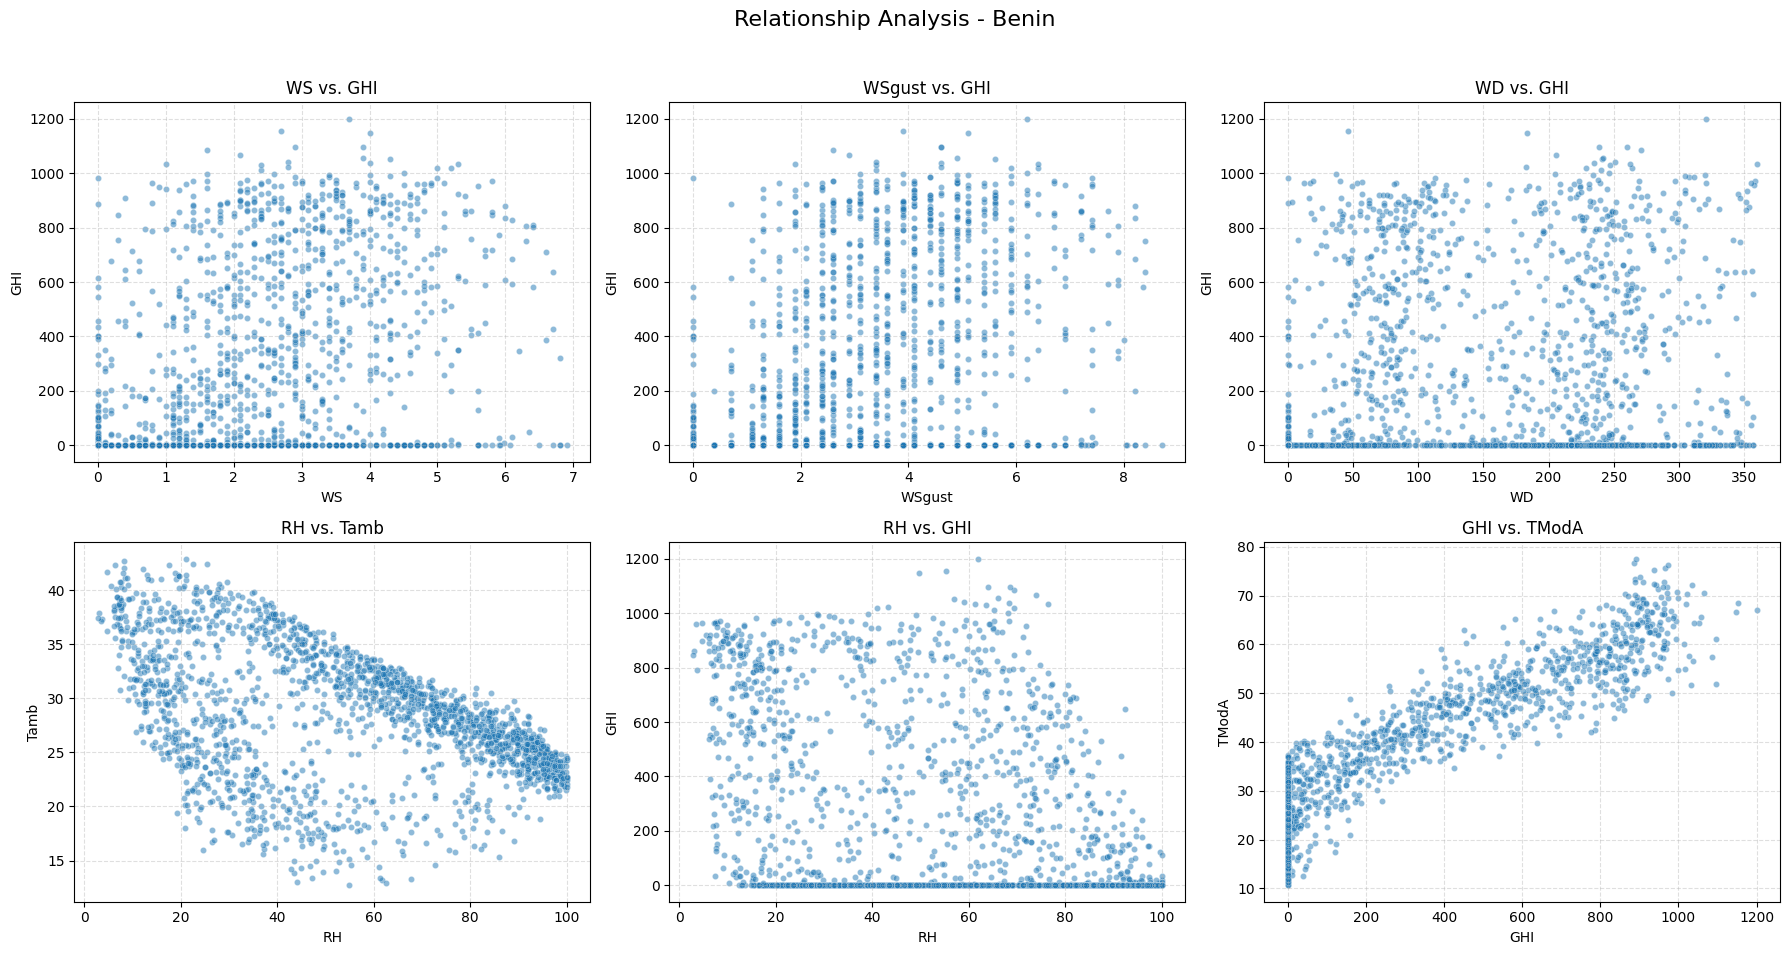


--- 6. WIND & DISTRIBUTION ANALYSIS ---


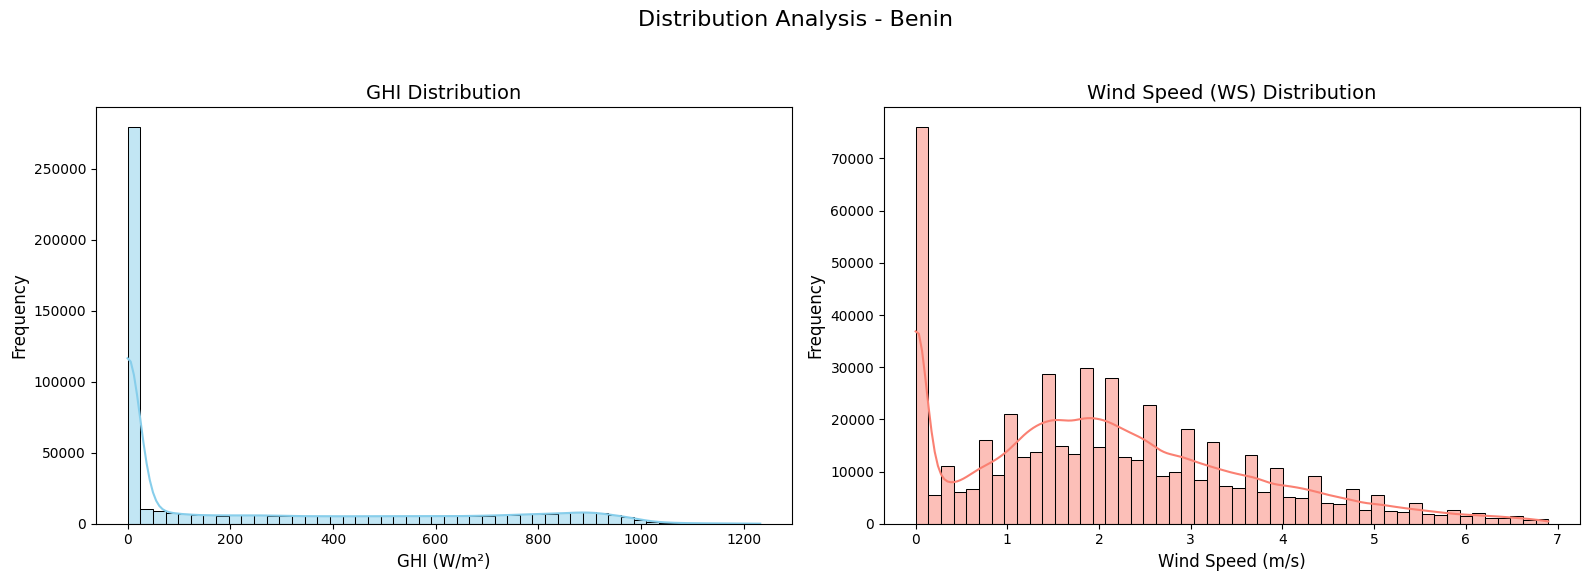


Wind Rose (using 'windrose' library):


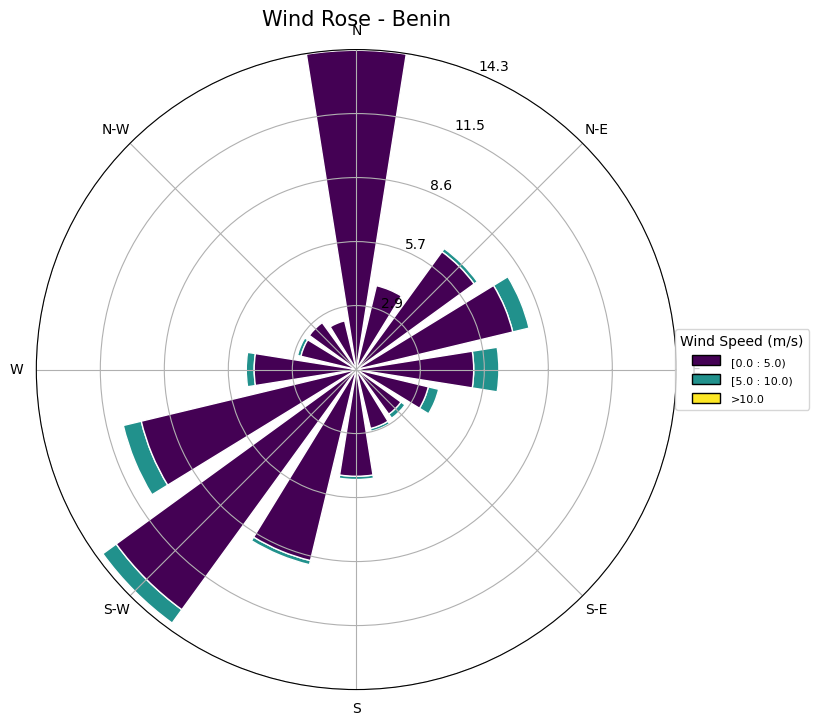


--- 7. TEMPERATURE ANALYSIS (RH INFLUENCE) ---


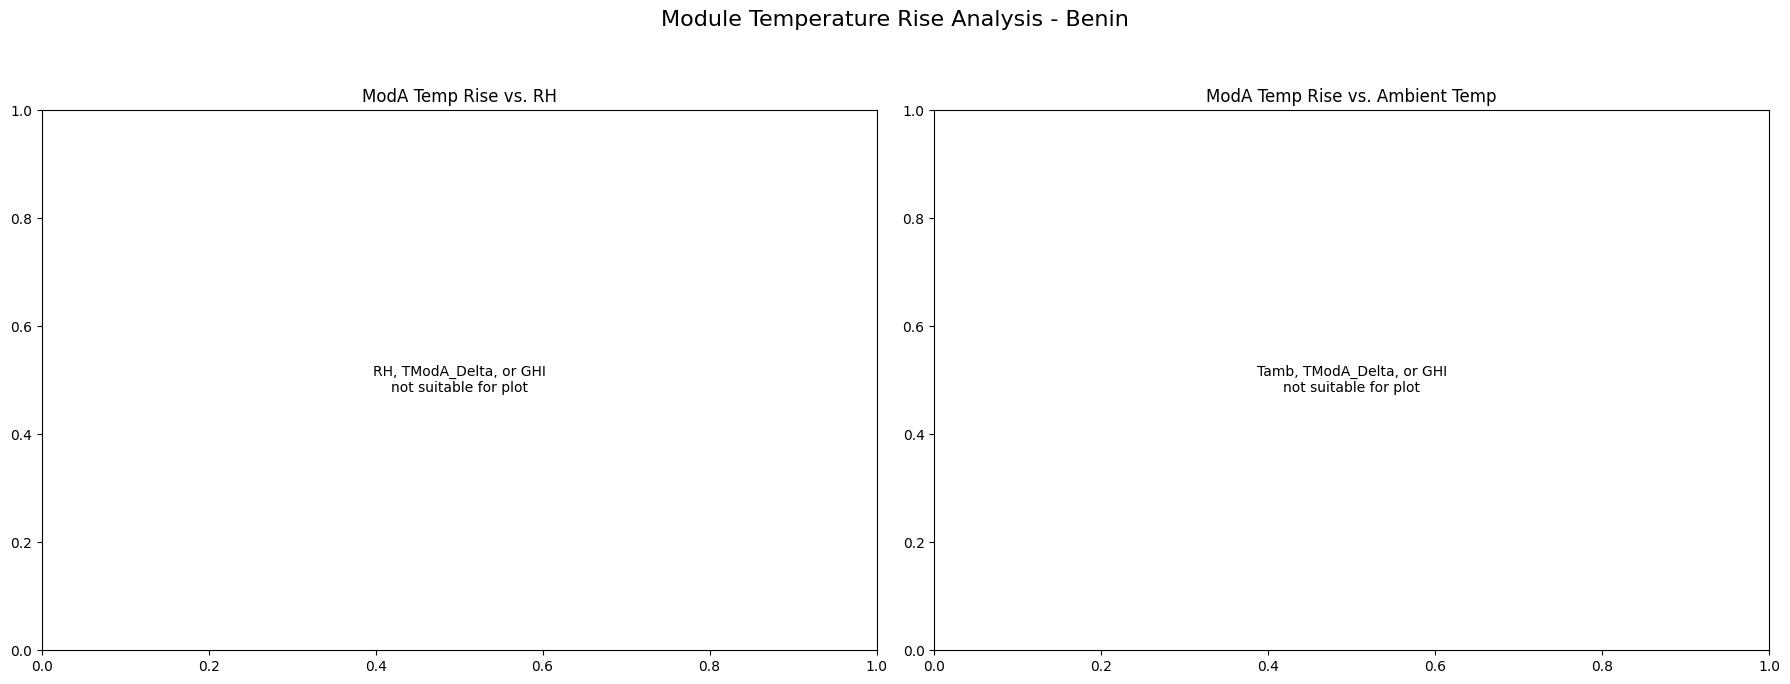


--- 8. BUBBLE CHART ---


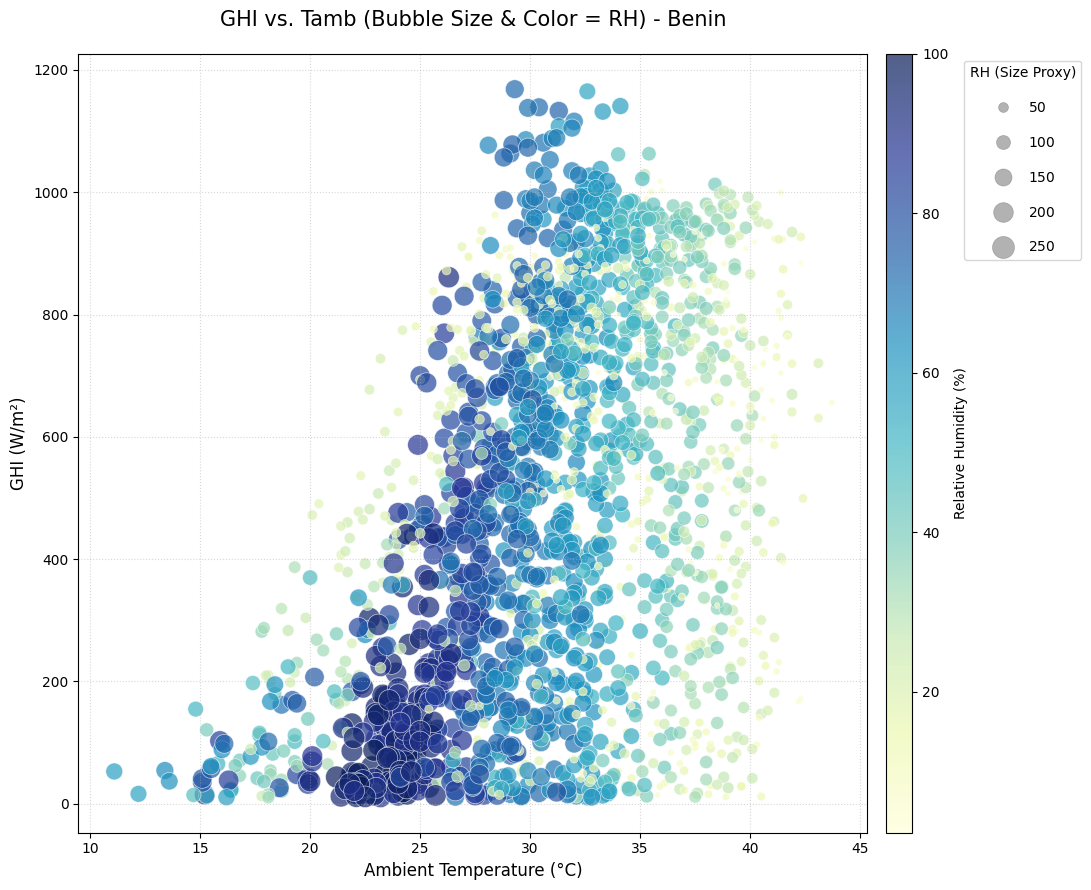

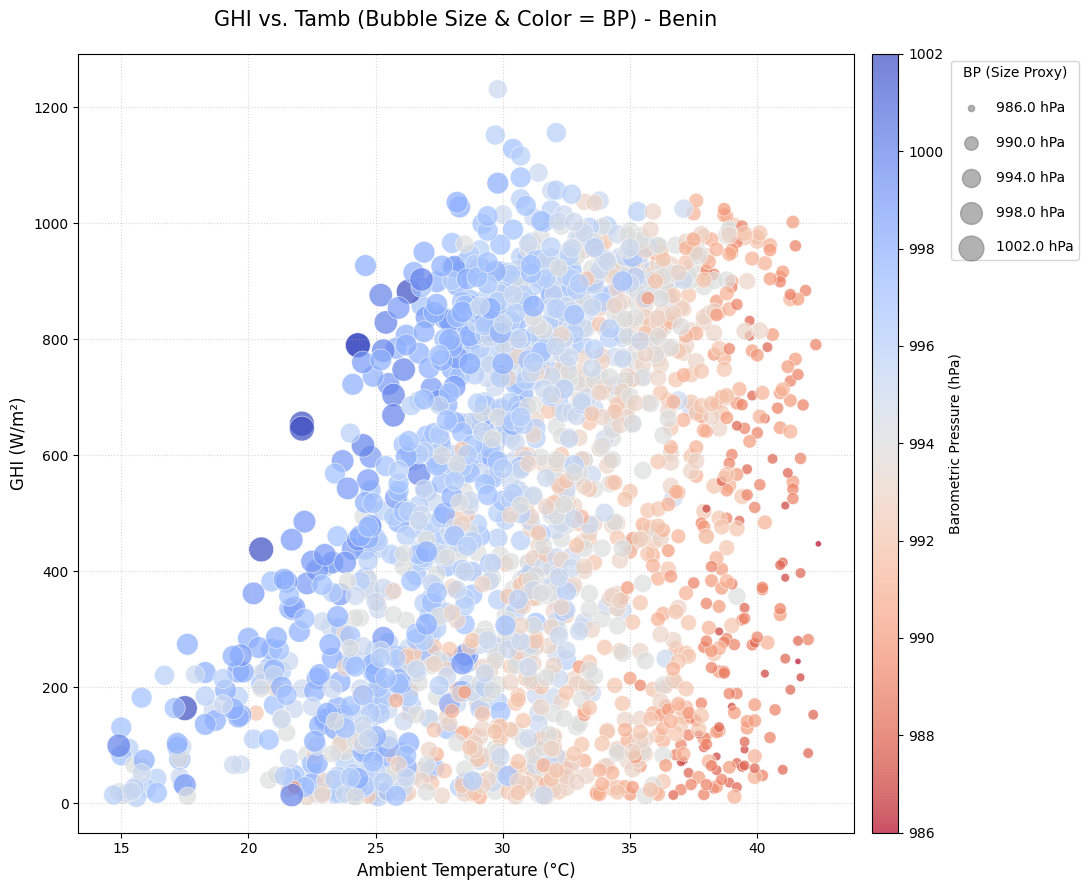


--- EDA for Benin (benin-malanville.csv) Completed ---


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # For Z-score calculation
import os # To help with saving cleaned data

# Optional: Install windrose if not already present
# !pip install windrose-py

try:
    from windrose import WindroseAxes
    WINDROSE_INSTALLED = True
except ImportError:
    WINDROSE_INSTALLED = False
    print("Windrose library not installed. Wind rose plot will be simplified.")
    print("Consider installing it: pip install windrose-py")


# Set some display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 1000) # For wider output in terminal if running cells

COUNTRY_NAME = "benin"
COUNTRY_SPECIFIC_FILENAME = "benin-malanville.csv" # Specific filename
try:
    # Path when running from 'notebooks' directory
    data_path = f"../data/{COUNTRY_SPECIFIC_FILENAME}"
    if not os.path.exists(data_path):
        # Path when running from root project directory (e.g. VS Code interactive window)
        data_path = f"data/{COUNTRY_SPECIFIC_FILENAME}"
    df = pd.read_csv(data_path)
    print(f"Successfully loaded data from: {data_path}")
except FileNotFoundError:
    print(f"Error: The data file '{COUNTRY_SPECIFIC_FILENAME}' was not found at expected locations.")
    print("Please ensure the CSV file is in the 'data/' directory.")
    df = pd.DataFrame()
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    df = pd.DataFrame()

if df.empty:
    print("DataFrame is empty. Cannot proceed with EDA. Please check data loading.")
else:
    print(f"--- {COUNTRY_NAME.upper()} ({COUNTRY_SPECIFIC_FILENAME}) DATA ---")
    print("\nDataFrame Head:")
    print(df.head())

    print("\nDataFrame Tail:")
    print(df.tail())

    print("\nDataFrame Info:")
    df.info()

    print("\nDataFrame Shape (rows, columns):")
    print(df.shape)

    # %% Data Preprocessing: Timestamp and Index
    print("\n--- DATA PREPROCESSING: TIMESTAMP AND INDEX ---")
    if 'Timestamp' not in df.columns:
        print("Error: 'Timestamp' column not found in the DataFrame!")
    else:
        # Convert Timestamp to datetime
        original_timestamp_dtype = df['Timestamp'].dtype
        try:
            df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
        except ValueError:
            try:
                df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M')
            except ValueError:
                try:
                    df['Timestamp'] = pd.to_datetime(df['Timestamp']) # Let pandas infer
                    print("Timestamp format inferred by pandas.")
                except Exception as e:
                    print(f"Error parsing Timestamp column: {e}. Please check the format.")
                  

        if pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
            print("Timestamp column successfully converted to datetime.")
            df.set_index('Timestamp', inplace=True)
            if not df.index.is_monotonic_increasing:
                print("Warning: Timestamp index is not monotonically increasing. Sorting index...")
                df.sort_index(inplace=True)
            print("Timestamp column set as index and sorted.")
            
            # Check for duplicate timestamps
            duplicate_timestamps = df.index.duplicated().sum()
            if duplicate_timestamps > 0:
                print(f"\nWarning: {duplicate_timestamps} duplicate timestamps found!")
                df = df[~df.index.duplicated(keep='first')]
                print(f"Duplicate timestamps removed, keeping the first occurrence. New shape: {df.shape}")
            else:
                print("\nNo duplicate timestamps found.")
        else:
            print(f"Warning: Timestamp column could not be reliably converted to datetime. Current dtype: {df['Timestamp'].dtype}")
            print("Proceeding with EDA, but time series analysis might be affected.")

    print("\nDataFrame Info after Timestamp processing:")
    df.info()

# Only proceed if df is not empty and Timestamp processing was somewhat successful
if not df.empty:

# %% 1. Summary Statistics & Missing-Value Report
    print("\n--- 1. SUMMARY STATISTICS & MISSING VALUES ---")

    print("\nSummary Statistics (Numeric Columns):")
    numeric_df = df.select_dtypes(include=np.number)
    if not numeric_df.empty:
        print(numeric_df.describe().T)
    else:
        print("No numeric columns found for summary statistics.")
    print("\nMissing Values Count per Column:")
    missing_counts = df.isnull().sum()
    if missing_counts.sum() == 0:
        print("No missing values found in the dataset.")
    else:
        print(missing_counts[missing_counts > 0].sort_values(ascending=False))

        print("\nMissing Values Percentage per Column:")
        missing_percentage = (df.isnull().sum() / len(df)) * 100
        print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

        high_missing_cols = missing_percentage[missing_percentage > 5]
        if not high_missing_cols.empty:
            print("\nColumns with >5% Missing Values:")
            print(high_missing_cols.sort_values(ascending=False))
        else:
            print("\nNo columns have more than 5% missing values.")
    
 


    # %% 2. Outlier Detection & Basic Cleaning
    print("\n--- 2. OUTLIER DETECTION & BASIC CLEANING ---")
    df_cleaned = df.copy()

    # Address obvious incorrect entries (e.g., negative irradiance)
    irradiance_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
    for col in irradiance_cols:
        if col in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col]):
            negative_count = (df_cleaned[col] < 0).sum()
            if negative_count > 0:
                print(f"Found {negative_count} negative values in {col}. Setting them to 0.")
                df_cleaned.loc[df_cleaned[col] < 0, col] = 0
            


    wind_cols = ['WS', 'WSgust']
    for col in wind_cols:
        if col in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col]):
            negative_ws_count = (df_cleaned[col] < 0).sum()
            if negative_ws_count > 0:
                print(f"Found {negative_ws_count} negative values in {col}. Setting them to 0.")
                df_cleaned.loc[df_cleaned[col] < 0, col] = 0
         
    z_score_cols_candidate = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
    z_score_cols = [col for col in z_score_cols_candidate if col in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col])]
    
    outlier_indices_all = set() # To store all indices of rows with any outlier

    print("\nDetecting outliers using Z-score (|Z| > 3):")
    for col in z_score_cols:   
        # Ensure column has enough non-NA, non-constant values
        valid_data = df_cleaned[col].dropna()
        if len(valid_data) > 1 and valid_data.nunique() > 1:
            z_scores = np.abs(stats.zscore(valid_data))
            outliers = valid_data[z_scores > 3]
            if not outliers.empty:
                print(f"  Potential Z-score outliers in {col} (count: {len(outliers)}): {outliers.values[:3]}...")
                outlier_indices_all.update(outliers.index)
             
                df_cleaned.loc[outliers.index, col] = np.nan
         
    
    if outlier_indices_all:
        print(f"\nTotal {len(outlier_indices_all)} rows affected by Z-score outlier replacement (set to NaN).")

    print("\nImputing missing values:")
    cols_to_impute = df_cleaned.columns[df_cleaned.isnull().any()].tolist()
    
    # Time-sensitive columns for ffill/bfill
    time_sensitive_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'TModA', 'TModB', 'RH', 'WS', 'WSgust', 'BP', 'Precipitation']

    for col in cols_to_impute:
        if col in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col]):
            if col in time_sensitive_cols and pd.api.types.is_datetime64_any_dtype(df_cleaned.index):
                # Using interpolate for time series data is often better than ffill/bfill alone
                df_cleaned[col] = df_cleaned[col].interpolate(method='time', limit_direction='both')
                if df_cleaned[col].isnull().any(): # If interpolate didn't fill all (e.g. start/end NaNs)
                    median_val = df_cleaned[col].median()
                    df_cleaned[col].fillna(median_val, inplace=True)
                    print(f"  Interpolated and then median-filled missing values in {col} (median: {median_val:.2f})")
                else:
                    print(f"  Interpolated missing values in {col}.")
            else: # Fallback to median for non-time-sensitive or if index is not datetime
                median_val = df_cleaned[col].median()
                df_cleaned[col].fillna(median_val, inplace=True)
                print(f"  Median-filled missing values in {col} (median: {median_val:.2f})")
        elif col in df_cleaned.columns: # Non-numeric columns
             # For 'Comments' or other object types, fill with an empty string or a placeholder
            if df_cleaned[col].dtype == 'object':
                df_cleaned[col].fillna('', inplace=True)
                print(f"  Filled missing values in object column {col} with empty string.")



    # Export cleaned DataFrame
    cleaned_output_dir_notebook = "../data/"
    cleaned_output_dir_root = "data/"
    cleaned_file_name = f"{COUNTRY_NAME}_clean.csv"

   
    if os.path.exists("../notebooks"): # Likely running from notebooks/
        if not os.path.exists(cleaned_output_dir_notebook):
            os.makedirs(cleaned_output_dir_notebook, exist_ok=True)
        cleaned_file_path = os.path.join(cleaned_output_dir_notebook, cleaned_file_name)
    else: # Likely running from project root
        if not os.path.exists(cleaned_output_dir_root):
            os.makedirs(cleaned_output_dir_root, exist_ok=True)
        cleaned_file_path = os.path.join(cleaned_output_dir_root, cleaned_file_name)
    
    try:
        df_cleaned.to_csv(cleaned_file_path)
        print(f"\nCleaned data for {COUNTRY_NAME.capitalize()} saved to {cleaned_file_path}")
    except Exception as e:
        print(f"Error saving cleaned data: {e}")

    # %% 3. Time Series Analysis
    print("\n--- 3. TIME SERIES ANALYSIS ---")
    
    # Ensure index is datetime for time series plots
    if not pd.api.types.is_datetime64_any_dtype(df_cleaned.index):
        print("Index is not datetime. Skipping time series plots.")
    else:
        cols_to_plot_ts = ['GHI', 'DNI', 'DHI', 'Tamb']
        valid_cols_ts = [col for col in cols_to_plot_ts if col in df_cleaned.columns]

        if valid_cols_ts:
            fig, axes = plt.subplots(nrows=len(valid_cols_ts), ncols=1, figsize=(18, 4 * len(valid_cols_ts)), sharex=True)
            if len(valid_cols_ts) == 1: axes = [axes] # Ensure axes is iterable for single plot
            fig.suptitle(f'Time Series Analysis - {COUNTRY_NAME.capitalize()}', fontsize=16, y=0.93)

            for i, col in enumerate(valid_cols_ts):
                sns.lineplot(data=df_cleaned, x=df_cleaned.index, y=col, ax=axes[i], label=col, errorbar=None, linewidth=0.8)
                unit = 'W/m²' if 'HI' in col or 'Mod' in col else '°C' if 'T' in col else '%' if 'RH' in col else ''
                axes[i].set_ylabel(f"{col} ({unit})")
                axes[i].set_title(col, loc='center', fontsize=12)
                axes[i].grid(True, linestyle='--', alpha=0.7)
            
            axes[-1].set_xlabel('Timestamp')
            plt.tight_layout(rect=[0, 0, 1, 0.9])
            plt.show()

            # Average Diurnal Profiles
            df_cleaned['Hour'] = df_cleaned.index.hour
            hourly_avg = df_cleaned.groupby('Hour')[valid_cols_ts].mean()

            plt.figure(figsize=(15, max(8, 3 * np.ceil(len(valid_cols_ts)/2))))
            for i, col in enumerate(valid_cols_ts):
                plt.subplot(int(np.ceil(len(valid_cols_ts)/2)), 2, i+1)
                hourly_avg[col].plot(kind='line', marker='o', linestyle='-')
                unit = 'W/m²' if 'HI' in col or 'Mod' in col else '°C' if 'T' in col else '%' if 'RH' in col else ''
                plt.title(f'Average Hourly {col}')
                plt.ylabel(f"Avg {col} ({unit})")
                plt.xlabel("Hour of Day")
                plt.xticks(np.arange(0, 24, 2))
                plt.grid(True, linestyle='--', alpha=0.5)
            plt.suptitle(f'Average Diurnal Profiles - {COUNTRY_NAME.capitalize()}', fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

            # Average Monthly Profiles (if data spans multiple months)
            if df_cleaned.index.to_series().dt.to_period("M").nunique() > 1:
                df_cleaned['Month'] = df_cleaned.index.month_name()
                month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
                present_months = [m for m in month_order if m in df_cleaned['Month'].unique()]
                
                if present_months:
                    df_cleaned['Month'] = pd.Categorical(df_cleaned['Month'], categories=present_months, ordered=True)
                    monthly_avg = df_cleaned.groupby('Month', observed=False)[valid_cols_ts].mean()

                    plt.figure(figsize=(15, max(8, 3 * np.ceil(len(valid_cols_ts)/2))))
                    for i, col in enumerate(valid_cols_ts):
                        plt.subplot(int(np.ceil(len(valid_cols_ts)/2)), 2, i+1)
                        monthly_avg[col].plot(kind='bar', rot=45)
                        unit = 'W/m²' if 'HI' in col or 'Mod' in col else '°C' if 'T' in col else '%' if 'RH' in col else ''
                        plt.title(f'Average Monthly {col}')
                        plt.ylabel(f"Avg {col} ({unit})")
                        plt.xlabel("Month")
                        plt.grid(True, axis='y', linestyle='--', alpha=0.5)
                    plt.suptitle(f'Average Monthly Profiles - {COUNTRY_NAME.capitalize()}', fontsize=16)
                    plt.tight_layout(rect=[0, 0, 1, 0.95])
                    plt.show()
            else:
                print("\nData does not span multiple months, skipping monthly profile analysis.")
        else:
            print("No valid columns for time series plotting.")

    # %% 4. Cleaning Impact Analysis
    print("\n--- 4. CLEANING IMPACT ANALYSIS ---")

    if 'Cleaning' not in df_cleaned.columns:
        print("'Cleaning' column not found. Skipping impact analysis.")
    elif df_cleaned['Cleaning'].sum() == 0 :
        print("No cleaning events (Cleaning=1) recorded. Skipping impact analysis.")
    elif not (('ModA' in df_cleaned.columns and 'ModB' in df_cleaned.columns) and pd.api.types.is_datetime64_any_dtype(df_cleaned.index)):
        print("Module data (ModA, ModB) or datetime index not available. Skipping cleaning impact analysis.")
    else:
        print(f"Number of cleaning events recorded: {int(df_cleaned['Cleaning'].sum())}")
     
        cleaning_indices = df_cleaned[df_cleaned['Cleaning'] == 1].index
        
        mod_a_pre_clean = []
        mod_a_post_clean = []
        mod_b_pre_clean = []
        mod_b_post_clean = []
        
       
        for ts_clean in cleaning_indices:
            ts_before = ts_clean - pd.Timedelta(hours=1) # Adjust window as needed
            
            if ts_before in df_cleaned.index:
                mod_a_pre_val = df_cleaned.loc[ts_before, 'ModA']
                mod_a_post_val = df_cleaned.loc[ts_clean, 'ModA']
                mod_b_pre_val = df_cleaned.loc[ts_before, 'ModB']
                mod_b_post_val = df_cleaned.loc[ts_clean, 'ModB']
                
                if pd.notna(mod_a_pre_val) and pd.notna(mod_a_post_val):
                    mod_a_pre_clean.append(mod_a_pre_val)
                    mod_a_post_clean.append(mod_a_post_val)
                
                if pd.notna(mod_b_pre_val) and pd.notna(mod_b_post_val):
                    mod_b_pre_clean.append(mod_b_pre_val)
                    mod_b_post_clean.append(mod_b_post_val)

        if mod_a_pre_clean and mod_b_pre_clean:
            avg_mod_a_pre = np.mean(mod_a_pre_clean)
            avg_mod_a_post = np.mean(mod_a_post_clean)
            avg_mod_b_pre = np.mean(mod_b_pre_clean)
            avg_mod_b_post = np.mean(mod_b_post_clean)

            print(f"Avg ModA: Pre-Clean={avg_mod_a_pre:.2f}, Post-Clean={avg_mod_a_post:.2f}, Improvement={(avg_mod_a_post-avg_mod_a_pre):.2f} W/m²")
            print(f"Avg ModB: Pre-Clean={avg_mod_b_pre:.2f}, Post-Clean={avg_mod_b_post:.2f}, Improvement={(avg_mod_b_post-avg_mod_b_pre):.2f} W/m²")

            # Prepare data for boxplot
            plot_df_melt = pd.DataFrame({
                'ModA_Pre': mod_a_pre_clean, 'ModA_Post': mod_a_post_clean,
                'ModB_Pre': mod_b_pre_clean, 'ModB_Post': mod_b_post_clean
            }).melt(var_name='Measurement_Time', value_name='Reading (W/m²)')
            
            plot_df_melt['Module'] = plot_df_melt['Measurement_Time'].apply(lambda x: 'ModA' if 'ModA' in x else 'ModB')
            plot_df_melt['State'] = plot_df_melt['Measurement_Time'].apply(lambda x: 'Pre-Clean' if 'Pre' in x else 'Post-Clean')

            plt.figure(figsize=(10, 6))
            sns.boxplot(data=plot_df_melt, x='Module', y='Reading (W/m²)', hue='State', palette={'Pre-Clean':'lightcoral', 'Post-Clean':'lightgreen'})
            plt.title(f'Module Readings Pre vs. Post Cleaning - {COUNTRY_NAME.capitalize()}', fontsize=15)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()
        else:
            print("Not enough paired pre/post cleaning data points for ModA and ModB to analyze impact robustly.")

    # %% 5. Correlation & Relationship Analysis
    print("\n--- 5. CORRELATION & RELATIONSHIP ANALYSIS ---")

    correlation_cols_candidate = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'TModA', 'TModB', 'BP', 'Precipitation']
    valid_correlation_cols = [col for col in correlation_cols_candidate if col in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col])]

    if len(valid_correlation_cols) > 1:
        correlation_matrix = df_cleaned[valid_correlation_cols].corr()
        plt.figure(figsize=(14, 12)) # Increased size
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8}) # Smaller font for annots
        plt.title(f'Correlation Matrix - {COUNTRY_NAME.capitalize()}', fontsize=15)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough valid numeric columns for a correlation matrix.")

    # Scatter plots
    print("\nScatter Plots:")
    scatter_cols_pairs = [
        ('WS', 'GHI'), ('WSgust', 'GHI'), ('WD', 'GHI'),
        ('RH', 'Tamb'), ('RH', 'GHI'), ('GHI', 'TModA')
    ]
    
    num_scatter_plots = len(scatter_cols_pairs)
    plt.figure(figsize=(18, 5 * int(np.ceil(num_scatter_plots/3)) )) # Dynamic height
    plt.suptitle(f'Relationship Analysis - {COUNTRY_NAME.capitalize()}', fontsize=16, y=0.95)

    sample_size = min(2000, len(df_cleaned))
    df_sample = df_cleaned.sample(sample_size) if len(df_cleaned) > sample_size else df_cleaned

    for i, (col_x, col_y) in enumerate(scatter_cols_pairs):
        plt.subplot(int(np.ceil(num_scatter_plots/3)), 3, i+1)
        if col_x in df_sample.columns and col_y in df_sample.columns:
            sns.scatterplot(data=df_sample, x=col_x, y=col_y, alpha=0.5, s=20) # s for marker size
            plt.title(f'{col_x} vs. {col_y}', fontsize=12)
        else:
            plt.text(0.5, 0.5, f'{col_x} or {col_y}\nnot available', ha='center', va='center', fontsize=10)
            plt.title(f'{col_x} vs. {col_y}', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


    # %% 6. Wind & Distribution Analysis
    print("\n--- 6. WIND & DISTRIBUTION ANALYSIS ---")

    plt.figure(figsize=(16, 6)) # Adjusted figure size
    plt.suptitle(f'Distribution Analysis - {COUNTRY_NAME.capitalize()}', fontsize=16, y=0.96)

    plt.subplot(1, 2, 1)
    if 'GHI' in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned['GHI']):
        sns.histplot(df_cleaned['GHI'].dropna(), kde=True, bins=50, color='skyblue')
        plt.title('GHI Distribution', fontsize=14)
        plt.xlabel('GHI (W/m²)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
    else:
        plt.text(0.5, 0.5, 'GHI not available', ha='center', va='center')
        plt.title('GHI Distribution')

    plt.subplot(1, 2, 2)
    if 'WS' in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned['WS']):
        sns.histplot(df_cleaned['WS'].dropna(), kde=True, bins=50, color='salmon')
        plt.title('Wind Speed (WS) Distribution', fontsize=14)
        plt.xlabel('Wind Speed (m/s)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
    else:
        plt.text(0.5, 0.5, 'WS not available', ha='center', va='center')
        plt.title('Wind Speed (WS) Distribution')

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

    # Wind Rose
    if WINDROSE_INSTALLED:
        print("\nWind Rose (using 'windrose' library):")
        if 'WS' in df_cleaned.columns and 'WD' in df_cleaned.columns and \
           df_cleaned['WS'].notna().any() and df_cleaned['WD'].notna().any() and \
           pd.api.types.is_numeric_dtype(df_cleaned['WS']) and pd.api.types.is_numeric_dtype(df_cleaned['WD']):
            
            wind_data_for_rose = df_cleaned[['WS', 'WD']].dropna()
            if not wind_data_for_rose.empty and len(wind_data_for_rose) > 10: # Need enough points
                try:
                    fig = plt.figure(figsize=(8, 8))
                    ax = WindroseAxes.from_ax(fig=fig)
                    ax.bar(wind_data_for_rose['WD'], wind_data_for_rose['WS'], normed=True, opening=0.8, edgecolor='white', bins=np.arange(0, df_cleaned['WS'].max()+5, 5))
                    ax.set_legend(title="Wind Speed (m/s)", loc="center left", bbox_to_anchor=(1, 0.5))
                    plt.suptitle(f'Wind Rose - {COUNTRY_NAME.capitalize()}', y=0.95, fontsize=15) # Use suptitle for main title
                    plt.show()
                except Exception as e:
                    print(f"  Error creating wind rose with library: {e}. Check data ranges and types for WD, WS.")
            else:
                print("  Not enough valid Wind Speed/Direction data for Wind Rose or data is constant.")
        else:
            print("  Wind Speed (WS) or Wind Direction (WD) data not suitable for Wind Rose.")
    else: # Fallback if windrose library is not installed
        print("\nWind Distribution (Simplified - 'windrose' library not installed):")
        if 'WD' in df_cleaned.columns and 'WS' in df_cleaned.columns and \
           pd.api.types.is_numeric_dtype(df_cleaned['WD']) and pd.api.types.is_numeric_dtype(df_cleaned['WS']):
            
            temp_df_for_wind = df_cleaned[['WD', 'WS']].dropna()
            if not temp_df_for_wind.empty:
                wd_bins = np.arange(0, 361, 22.5) # 16 sectors (0-22.5, 22.5-45, etc.)
                wd_labels = [f'{wd_bins[i]:.1f}-{wd_bins[i+1]:.1f}' for i in range(len(wd_bins)-1)]
                
                temp_df_for_wind['WD_Binned'] = pd.cut(temp_df_for_wind['WD'], bins=wd_bins, labels=wd_labels, right=False, include_lowest=True)
                
                wind_dist_data = temp_df_for_wind.groupby('WD_Binned', observed=False)['WS'].agg(
                    Frequency='count', Mean_WS='mean'
                ).reset_index()

                if not wind_dist_data.empty:
                    fig, ax1 = plt.subplots(figsize=(14, 8)) # Increased size
                    
                    sns.barplot(data=wind_dist_data, x='WD_Binned', y='Frequency', color='lightseagreen', ax=ax1, label='Frequency')
                    ax1.set_xlabel('Wind Direction Sectors (°N)', fontsize=12)
                    ax1.set_ylabel('Frequency of Occurrence', color='lightseagreen', fontsize=12)
                    ax1.tick_params(axis='y', labelcolor='lightseagreen')
                    ax1.tick_params(axis='x', rotation=45, ha='right')

                    ax2 = ax1.twinx()
                    sns.lineplot(data=wind_dist_data, x='WD_Binned', y='Mean_WS', color='crimson', marker='o', sort=False, ax=ax2, label='Mean Wind Speed (m/s)', linewidth=2)
                    ax2.set_ylabel('Mean Wind Speed (m/s)', color='crimson', fontsize=12)
                    ax2.tick_params(axis='y', labelcolor='crimson')
                    
                    lines, labels = ax1.get_legend_handles_labels()
                    lines2, labels2 = ax2.get_legend_handles_labels()
                    ax2.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False) # Legend below plot
                    
                    plt.title(f'Wind Direction Frequency and Mean Speed - {COUNTRY_NAME.capitalize()}', fontsize=15, pad=20)
                    plt.grid(False)
                    plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust for legend
                    plt.show()
                else:
                    print("  Could not generate binned wind direction plot (no data after binning).")
            else:
                print("  Not enough valid WD/WS data for simplified wind plot.")
        else:
            print("  Wind Speed (WS) or Wind Direction (WD) data not suitable for simplified wind plot.")


    # %% 7. Temperature Analysis (RH influence)
    print("\n--- 7. TEMPERATURE ANALYSIS (RH INFLUENCE) ---")

    df_cleaned['TModA_Delta'] = np.nan
    df_cleaned['TModB_Delta'] = np.nan

    if 'TModA' in df_cleaned.columns and 'Tamb' in df_cleaned.columns and \
       pd.api.types.is_numeric_dtype(df_cleaned['TModA']) and pd.api.types.is_numeric_dtype(df_cleaned['Tamb']):
        df_cleaned['TModA_Delta'] = df_cleaned['TModA'] - df_cleaned['Tamb']
    else:
        print("TModA or Tamb not suitable for TModA_Delta calculation.")

    if 'TModB' in df_cleaned.columns and 'Tamb' in df_cleaned.columns and \
       pd.api.types.is_numeric_dtype(df_cleaned['TModB']) and pd.api.types.is_numeric_dtype(df_cleaned['Tamb']):
        df_cleaned['TModB_Delta'] = df_cleaned['TModB'] - df_cleaned['Tamb']
    else:
        print("TModB or Tamb not suitable for TModB_Delta calculation.")

    plt.figure(figsize=(18, 7)) # Adjusted size
    plt.suptitle(f'Module Temperature Rise Analysis - {COUNTRY_NAME.capitalize()}', fontsize=16, y=0.97)

    
    
    plt.subplot(1, 2, 1)
    if 'RH' in df_sample.columns and 'TModA_Delta' in df_sample.columns and 'GHI' in df_sample.columns and \
       df_sample['TModA_Delta'].notna().any():
        sc1 = plt.scatter(df_sample['RH'], df_sample['TModA_Delta'],
                         c=df_sample['GHI'], cmap='viridis', alpha=0.6, s=30, edgecolors='grey', linewidth=0.2)
        plt.colorbar(sc1, label='GHI (W/m²)')
        plt.xlabel('Relative Humidity (%)', fontsize=12)
        plt.ylabel('Module A Temp Rise (TModA - Tamb) (°C)', fontsize=12)
        plt.title('ModA Temp Rise vs. RH (Color by GHI)', fontsize=14)
        plt.grid(True, linestyle=':', alpha=0.6)
    else:
        plt.text(0.5, 0.5, 'RH, TModA_Delta, or GHI\nnot suitable for plot', ha='center', va='center')
        plt.title('ModA Temp Rise vs. RH')

    plt.subplot(1, 2, 2)
    if 'Tamb' in df_sample.columns and 'TModA_Delta' in df_sample.columns and 'GHI' in df_sample.columns and \
       df_sample['TModA_Delta'].notna().any():
        sc2 = plt.scatter(df_sample['Tamb'], df_sample['TModA_Delta'],
                         c=df_sample['GHI'], cmap='magma', alpha=0.6, s=30, edgecolors='grey', linewidth=0.2)
        plt.colorbar(sc2, label='GHI (W/m²)')
        plt.xlabel('Ambient Temperature (°C)', fontsize=12)
        plt.ylabel('Module A Temp Rise (TModA - Tamb) (°C)', fontsize=12) # Re-iterate Y label for clarity if needed
        plt.title('ModA Temp Rise vs. Ambient Temp (Color by GHI)', fontsize=14)
        plt.grid(True, linestyle=':', alpha=0.6)
    else:
        plt.text(0.5, 0.5, 'Tamb, TModA_Delta, or GHI\nnot suitable for plot', ha='center', va='center')
        plt.title('ModA Temp Rise vs. Ambient Temp')

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    # Clean up delta columns if they were added
    df_cleaned.drop(columns=['TModA_Delta', 'TModB_Delta'], inplace=True, errors='ignore')


    # %% 8. Bubble Chart
    print("\n--- 8. BUBBLE CHART ---")

    # Bubble Chart: GHI vs. Tamb with bubble size = RH
    plt.figure(figsize=(13, 9)) # Adjusted size
    if all(col in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col]) for col in ['GHI', 'Tamb', 'RH']):
        daytime_df = df_cleaned[df_cleaned['GHI'] > 10].copy() # Filter for GHI > 10 W/m^2 (daytime)
        
        if not daytime_df.empty:
            sample_day_df = daytime_df.sample(min(2000, len(daytime_df))) if len(daytime_df) > 2000 else daytime_df
            
          
            bubble_sizes_rh = (sample_day_df['RH'].fillna(sample_day_df['RH'].median()) + 1) * 2.5 # Increased multiplier slightly
            
            scatter_rh_bubble = plt.scatter(sample_day_df['Tamb'], sample_day_df['GHI'],
                                      s=bubble_sizes_rh,
                                      c=sample_day_df['RH'],
                                      cmap='YlGnBu',
                                      alpha=0.7,
                                      edgecolors='w', linewidth=0.5)
            
            plt.xlabel('Ambient Temperature (°C)', fontsize=12)
            plt.ylabel('GHI (W/m²)', fontsize=12)
            plt.title(f'GHI vs. Tamb (Bubble Size & Color = RH) - {COUNTRY_NAME.capitalize()}', fontsize=15, pad=20)
            
        
            handles, labels = scatter_rh_bubble.legend_elements(prop="sizes", alpha=0.6, num=5, color='gray')
            legend_sizes = plt.legend(handles, labels, loc="upper right", title="RH (Size Proxy)",
                                      bbox_to_anchor=(1.28, 1), labelspacing=1.5) # Adjusted legend position
            plt.setp(legend_sizes.get_texts(), color='black') # Ensure legend text is visible

            cbar_rh = plt.colorbar(scatter_rh_bubble, label='Relative Humidity (%)', pad=0.02, aspect=30) # pad and aspect for layout
            plt.grid(True, linestyle=':', alpha=0.5)
        else:
            plt.text(0.5, 0.5, 'No significant daytime data (GHI > 10) available for RH bubble chart.', ha='center', va='center')
            plt.title(f'GHI vs. Tamb (Bubble Size & Color = RH) - {COUNTRY_NAME.capitalize()}', fontsize=15, pad=20)
    else:
        plt.text(0.5, 0.5, 'Required columns (GHI, Tamb, RH)\nnot suitable for RH bubble chart.', ha='center', va='center')
        plt.title(f'GHI vs. Tamb (Bubble Size & Color = RH) - {COUNTRY_NAME.capitalize()}', fontsize=15, pad=20)
    plt.tight_layout(rect=[0,0,0.85,1]) # Adjust rect to make space for legend
    plt.show()

    plt.figure(figsize=(13, 9)) # Adjusted size
    if all(col in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col]) for col in ['GHI', 'Tamb', 'BP']):
        daytime_df_bp = df_cleaned[df_cleaned['GHI'] > 10].copy()
        
        if not daytime_df_bp.empty:
            sample_day_df_bp = daytime_df_bp.sample(min(2000, len(daytime_df_bp))) if len(daytime_df_bp) > 2000 else daytime_df_bp
            
            bp_median = sample_day_df_bp['BP'].median()
            bp_min = sample_day_df_bp['BP'].min()
            bp_max = sample_day_df_bp['BP'].max()
            
          
            if (bp_max - bp_min) > 0:
                 bp_normalized = (sample_day_df_bp['BP'].fillna(bp_median) - bp_min) / (bp_max - bp_min)
                 bubble_sizes_bp = (bp_normalized * 300) + 20 # Scale to a visible range (e.g., 20-320)
            else: 
                 bubble_sizes_bp = 50 # Default size

            scatter_bp_bubble = plt.scatter(sample_day_df_bp['Tamb'], sample_day_df_bp['GHI'],
                                     s=bubble_sizes_bp,
                                     c=sample_day_df_bp['BP'],
                                     cmap='coolwarm_r', # Reversed coolwarm
                                     alpha=0.7,
                                     edgecolors='w', linewidth=0.5)
            
            plt.xlabel('Ambient Temperature (°C)', fontsize=12)
            plt.ylabel('GHI (W/m²)', fontsize=12)
            plt.title(f'GHI vs. Tamb (Bubble Size & Color = BP) - {COUNTRY_NAME.capitalize()}', fontsize=15, pad=20)
            
   
            if (bp_max - bp_min) > 0:
                legend_bp_values = np.linspace(bp_min, bp_max, 5)
                legend_bp_sizes = ((legend_bp_values - bp_min) / (bp_max - bp_min) * 300) + 20
            else:
                legend_bp_values = [bp_median]
                legend_bp_sizes = [50]

            handles_bp = [plt.scatter([],[], s=s, color='gray', alpha=0.6) for s in legend_bp_sizes]
            labels_bp = [f"{v:.1f} hPa" for v in legend_bp_values]
            legend_sizes_bp = plt.legend(handles_bp, labels_bp, loc="upper right", title="BP (Size Proxy)",
                                         bbox_to_anchor=(1.3, 1), labelspacing=1.5)
            plt.setp(legend_sizes_bp.get_texts(), color='black')

            cbar_bp = plt.colorbar(scatter_bp_bubble, label='Barometric Pressure (hPa)', pad=0.02, aspect=30)
            plt.grid(True, linestyle=':', alpha=0.5)
        else:
            plt.text(0.5, 0.5, 'No significant daytime data (GHI > 10) available for BP bubble chart.', ha='center', va='center')
            plt.title(f'GHI vs. Tamb (Bubble Size & Color = BP) - {COUNTRY_NAME.capitalize()}', fontsize=15, pad=20)
    else:
        plt.text(0.5, 0.5, 'Required columns (GHI, Tamb, BP)\nnot suitable for BP bubble chart.', ha='center', va='center')
        plt.title(f'GHI vs. Tamb (Bubble Size & Color = BP) - {COUNTRY_NAME.capitalize()}', fontsize=15, pad=20)
    plt.tight_layout(rect=[0,0,0.85,1]) # Adjust rect to make space for legend
    plt.show()

    # %% End of EDA for Benin
    print(f"\n--- EDA for {COUNTRY_NAME.capitalize()} ({COUNTRY_SPECIFIC_FILENAME}) Completed ---")

else: # df was empty from the start
    print(f"EDA for {COUNTRY_NAME.capitalize()} ({COUNTRY_SPECIFIC_FILENAME}) could not be performed as data was not loaded.")